<b><font size="+3">Финальный проект для курса "Otus Data Science"</font></b>

<font size="+2">Этап A: Тестирование методов глубокого обучения с подкреплением
на примере задачи обратного маятника (openai gym cartpole)</font>

# План исследования:
    Этап A. исследование методов обучения с подкреплением на простой модели (OpenAI Gym Cartpole)
        1. Построение работающей модели
        2. Tестирование оптимизационных изменений модели 
            - структуры нейросети
            - выбор оптимизатора
            - выбор активации
            - выбор функции ошибки
            - выбор параметра/функции Epsilon 
            - выбор параметра дисконтирования (gamma)
            - Алгоритмы выбора подвыборки для обучения
            - размер подвыборки (bath size)
            - частота обновления target network
            - error clipping (ограничение значений ошибки)
            - Double DQN
            - Dueling DQN           
    
    Этап  B. Построение и оптимизация модели работающей с видео выходом (OpenAI Gym Racer)
    
    Этап  C. Обучение модели для игры в простую настольную игру ("Connect Four")
    

**Источники:**

“Human-level control through deep reinforcement learning” https://storage.googleapis.com/deepmind-media/dqn/DQNNaturePaper.pdf

“Playing Atari with Deep Reinforcement Learning”
https://arxiv.org/pdf/1312.5602v1.pdf

“Deep Reinforcement Learning with Double Q-learning”
https://arxiv.org/pdf/1509.06461.pdf

“Dueling Network Architectures for Deep Reinforcement Learning”
https://arxiv.org/pdf/1511.06581.pdf

Udemy Course "Reinforcement Learning with Pytorch" (with some code borrowed) https://www.udemy.com/reinforcement-learning-with-pytorch/

# Experiments Setup

### imports

In [2]:
import numpy as np
import random
import math
import time
import copy
from PIL import Image
from itertools import zip_longest
from tqdm import tqdm_notebook

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
Tensor = torch.Tensor
LongTensor = torch.LongTensor

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
print(f"Torch: {torch.__version__}, device: {device}")

Torch: 1.2.0, device: cpu


### aux functions

In [4]:
"""GYM setup"""
# gym source code: https://github.com/openai/gym/blob/master/gym/envs/classic_control/cartpole.py
        
import gym
env = gym.make('CartPole-v0')
number_of_inputs = env.observation_space.shape[0]
number_of_outputs = env.action_space.n

seed_value = 42
env.seed(seed_value)
torch.manual_seed(seed_value)
random.seed(seed_value)

max_steps = 200 # get_from Gym
score_to_solve = max_steps - 5

### epsilon function

0.3742006467597279 0.010044945930464861


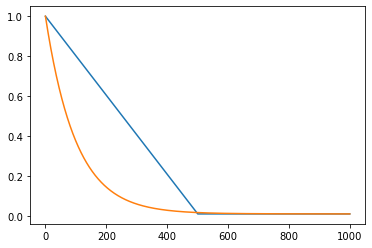

In [5]:
def get_epsilon(step, params=None):
    """Epsilon adjustment function (exponential)"""
    if params is None:
        params = {'start': 1, 'end': 0.01, 'decay': 100}  # <= defaults
    return params['end'] + (params['start']-params['end']) * \
        math.exp(-1. * step / params['decay'])

def get_epsilon_linear(step, params=None):
    """ Epsilon adjustment function (linear)"""
    if params is None:
        params = {'start': 1, 'end': 0.01, 'period': 500}  # <= defaults
    return params['start'] - min(params['period'], step) * \
        (params['start']-params['end']) / params['period'] 
    
plt.plot([get_epsilon_linear(s, None) for s in range (1000)])
plt.plot([get_epsilon(s, None) for s in range (1000)])

print(get_epsilon(100), get_epsilon(1000))

### memory

In [6]:
replay_mem_size = 10000

class ReplayMemory(object):
    """ basic memry class from Torch example """
    def __init__(self, capacity=replay_mem_size):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, state, action, new_state, reward, done):
        transition = (state, action, new_state, reward, done)

        if self.position >= len(self.memory):
            self.memory.append(transition)
        else:
            self.memory[self.position] = transition

        self.position = (self.position + 1) % self.capacity

    def push_batch (self, batch):
        for state, action, new_state, reward, done in batch:
            self.push (state, action, new_state, reward, done)
            
    def sample(self, batch_size):
        return zip(*random.sample(self.memory, batch_size))
    
    def reset (self):
        self.memory = []
        self.position = 0

    def __len__(self):
        return len(self.memory)

class ReplayMemory3(ReplayMemory):
    """ variant with separate list of keys for deduplication"""
    def __init__(self, capacity=10000):
        self.capacity = capacity
        self.memory = []
        self.keys=[]
        self.position = 0

    def push(self, state, action, new_state, reward, done):
        transition = (state, action, new_state, reward, done)

        if self.position >= len(self.memory):
            self.memory.append(transition)
        else:
            self.memory[self.position] = transition
        self.position = (self.position + 1) % self.capacity

    def reset (self):
        self.memory = []
        self.position = 0


class ReplayMemory4():
    """ Uses separate memories for positive and negative experiences """
    def __init__(self, capacity=10000):
        self.capacity = capacity
        self.positives = ReplayMemory3(capacity=capacity//2)
        self.negatives = ReplayMemory3(capacity=capacity//2)

    def push_batch (self, batch):
        posi_batch = [b for b in batch if b[3]>0.9]
        nega_batch = [b for b in batch if b[3]<=0.9]
        self.positives.push_batch(posi_batch)
        self.negatives.push_batch(nega_batch)
    
    def push(self, state, action, new_state, reward, done):
        raise NotimplementedError
        
    def sample(self, batch_size):
        posi_size = min (len(self.positives), batch_size//2)
        nega_size = min (len(self.negatives), batch_size - posi_size)
        if nega_size < batch_size //2:
            posi_size = batch_size - nega_size
        posi_sample = list(self.positives.sample(posi_size))
        nega_sample = list(self.negatives.sample(nega_size))
        return [p+n for p, n in zip_longest (posi_sample, nega_sample)]
    
    def reset (self):
        self.positives.reset()
        self.negatives.reset()
                
    def __len__(self):
        return min(self.positives.__len__(), self.negatives.__len__())*2

### Neural Networks

In [7]:
""" NEURAL NETWORKS """
activations = {'relu': nn.ReLU, 'tanh': nn.Tanh}

class NeuralNetwork(nn.Module):
    """
    NN class with FC layers only
    :param hidden: iterable of FC layer sizes
    """
    def __init__(self, hidden, inputs=number_of_inputs, outputs=number_of_outputs, 
                 activation='relu'):
        super(NeuralNetwork, self).__init__()
        layers = [inputs] + hidden + [outputs]
        layers_number = len(layers) - 1
        self.fc_list= nn.ModuleList()
        for i in range (layers_number):
            self.fc_list.append(nn.Linear(layers[i],layers[i+1]))

        self.activation = activations[activation]()

    def forward(self, x):
        out = self.fc_list[0](x)
        for i in range (1, self.fc_list.__len__()):
            out = self.activation(out)
            out = self.fc_list[i](out)
        return out

class NeuralNetwork_Dueling(nn.Module):
    """ Dualing NN based on Udemy example """
    def __init__(self, hidden=32, inputs=number_of_inputs, outputs=number_of_outputs, 
                 activation='relu'):
        super(NeuralNetwork_Dueling, self).__init__()
        self.linear1 = nn.Linear(inputs,hidden)
        self.advantage = nn.Linear(hidden, outputs)
        self.value = nn.Linear(hidden, 1)
        self.activation = activations[activation]()

    def forward(self, x):
        out1 = self.linear1(x)
        out1 = self.activation(out1)       
        out_adv = self.advantage(out1)
        out_val = self.value(out1)
        out = out_val + out_adv - out_adv.mean()
        return out  

### Learning agent

In [8]:
""" LEARNING AGENT """
# optimizers = {"adam": optim.Adam, "rmsprop": optim.RMSprop, "sgd": optim.SGD}



class Agent_DQN(object):
    def __init__(self, name, net, optimizer="adam", lr=0.01, batch_size=32,
                 double_dqn=False, clip_error=True, update_target_frequency=10,
                 gamma=0.9999, loss_func='smooth_l1'):
        self.name = name
        self.double_dqn = double_dqn
        self.clip_error = clip_error
        self.batch_size = batch_size
        self.update_target_frequency = update_target_frequency
        self.gamma = gamma

        self.memory = ReplayMemory4()
        self.history = {'name': self.name, 'score': []}

        self.nn = net.to(device)
        self.target_nn = copy.deepcopy(self.nn).to(device)

        loss_functions = {'mse': nn.MSELoss, 'smooth_l1': nn.SmoothL1Loss}
        self.loss_func = loss_functions[loss_func]()

        if optimizer == 'sgd':
            self.optimizer = optim.SGD(
                params=self.nn.parameters(), lr=lr, momentum=0.9)
        elif optimizer == 'rmsprop':
            self.optimizer = optim.RMSprop(params=self.nn.parameters(), lr=lr)
        else:
            self.optimizer = optim.Adam(params=self.nn.parameters(), lr=lr)

        self.update_target_counter = 0
        self.reset()
    
    @staticmethod
    def weight_reset(m):
        """resets NN weights for FC and Conv layers """
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
            m.reset_parameters()
            
    def reset(self):
        self.nn.apply(self.weight_reset)
        self.update_target_net()
        self.memory.reset()
        self.history = {'name': self.name, 'score': []}
        self.update_target_counter = 0

    def transform_state(self, state):
        return torch.Tensor(state).unsqueeze(0).to(device)

    def select_action(self, state, epsilon):
        if torch.rand(1)[0] > epsilon:
            with torch.no_grad():
                state = Tensor(state).to(device)
                action_from_nn = self.nn(state)
                action = torch.max(action_from_nn, -1).indices.item()
        else:
            action = env.action_space.sample()
        return action

    def optimize(self, verbose=False, batch_size=None):
        if batch_size is None:
            batch_size = self.batch_size
        if len(self.memory) < batch_size:
            return
        sample = self.memory.sample(batch_size)
        self.optimize_engine(sample, verbose)

    def optimize_engine(self, sample, verbose=False):
        """ optimization routine
        optimizes self.nn weights based on 1 run of sample batch
        sample: tuple (state, action, new_state, reward, done)
        sample dimensions = (batch_size, state dimension(s))
        """
        global state

        state, action, new_state, reward, done = sample
        state_batch = torch.cat(state).to(device)
        new_state = torch.cat(new_state).to(device)
        reward_batch = torch.cat(reward).to(device)

        action = LongTensor(action).to(device)
        done = Tensor(done).to(device)

        if self.double_dqn:  # idea from Udemy course
            new_state_indexes = self.nn(new_state).detach()
            max_new_state_indexes = torch.max(new_state_indexes, 1)[1]

            new_state_values = self.target_nn(new_state).detach()
            max_new_state_values = new_state_values.gather(
                1, max_new_state_indexes.unsqueeze(1)).squeeze(1)
        else:
            new_state_values = self.target_nn(new_state).detach()
            max_new_state_values = torch.max(new_state_values, 1)[0]

        target_value = reward_batch + \
            (1 - done) * self.gamma * max_new_state_values  # Bellman Equation
        predicted_value = self.nn(state_batch).gather(
            1, action.unsqueeze(1)).squeeze(1)

        loss = self.loss_func(predicted_value, target_value)
        self.optimizer.zero_grad()
        loss.backward()

        if self.clip_error:  # limit error - idea from Deepmind’s paper:
            for param in self.nn.parameters():
                param.grad.data.clamp_(-1, 1)

        self.optimizer.step()

        if self.update_target_counter % self.update_target_frequency == 0:
            self.update_target_net()

        self.update_target_counter += 1

    def update_target_net(self):
        self.target_nn.load_state_dict(self.nn.state_dict())

### LAB for experiments

In [9]:
def transform_run_history(run_history):
    """ исправляет историю перед отправкой в память
    добавляет отрицательные награды в последние шаги перед падением
    если история короче максимума"""
    loss_score = -1.0
    if len (run_history) < max_steps:
        run_history[-1][3] *= loss_score
        run_history[-2][3] *= loss_score / 2.0
        run_history[-3][3] *= 0
    return run_history

In [10]:
class Lab(object):
    """ 
    запускает тесты в Open.ai gym environment 
    в режимах обучения и тестирования
    """
    
    def __init__(self, env=gym.make('CartPole-v0')):
        self.env = env
        self.max_steps = 200

    def test(self, agent, episodes=5, min_score=195, max_steps=200, verbose=0):
        """
        Runs multiple episodes to chech whether agent can reach target score
        """
        start_time = time.time()
        for i_episode in range(episodes):
            result, _ = self.run_episode(agent, training=False)
            if verbose > 0:
                print(f" test:{i_episode}, score:{result}")
            elapsed_time = time.time() - start_time  # to be used

            if result < min_score:
                if verbose > 0:
                    print("TEST FAILED...")
                return False
        if verbose > 0:
            print("TEST PASSED !")
        return True

    def train(self, agent, max_episodes=1000,  verbose=0,  epsilon_params=None,
              report_interval=10, ):
        """
        Runs multiple episodes to checл whether agent can reach target score
        :param agent: Agent to be trained
        :param max_episodes:
        :param verbose: 0=none, 1, 2
        :param epsilon_params: tuple of 3 numbers for epsilon function 
        :param report_interval: episodes between brief reports (if verbose > 0)
        """
        start_time = time.time()
        solved = False

        for i_episode in range(1, max_episodes+1):
            epsilon = get_epsilon(i_episode, epsilon_params)
            
            result, run_history = self.run_episode(
                agent, training=True, epsilon=epsilon)
            
            elapsed_time = time.time() - start_time

            run_history = transform_run_history(run_history)
            agent.memory.push_batch(run_history)
#             agent.optimize()  # optimize after each step in the run_episode loop instead

            agent.history['score'].append(result)
            if i_episode % report_interval == 0 and verbose >= 2:
                print(f"Episode {i_episode}: "
                      f"Last {report_interval} average: {sum(agent.history['score'][-report_interval:])/report_interval:.1f}; "
                      f"Eps: {epsilon:.3f}, "
                      "Elapsed:", time.strftime("%M:%S", time.gmtime(elapsed_time)))

            if not solved and result >= score_to_solve:
                if self.test(agent):
                    if verbose >= 1:
                        print("SOLVED! After %i episodes " % i_episode)
                    solved_after = i_episode
                    solved = True
                    break
        agent.history['elapsed_time'] = elapsed_time
        agent.history['episodes'] = i_episode

        if verbose >= 1:
            print(
                f"Elapsed {elapsed_time:.2f}s, per episode:{elapsed_time/i_episode:.2f}s, ")

    def run_episode(self, agent, training=False, epsilon=0, verbose=1):
        """
        runs single episode of gym with Agent
        calls NN optimization function in training mode
        """
        state = self.env.reset()
        state = agent.transform_state(state)
        run_history = []
        counter = 0
        done = False

        for step in range(1, self.max_steps+1):  # and counter < max_steps:
            action = agent.select_action(state, epsilon)

            new_state, reward, done, info = self.env.step(action)
            new_state = agent.transform_state(new_state)

            if training:
                if done and step < 190:
                    reward = -1.0  # tweak to add negative reward
                reward = torch.tensor([reward], device=device)
                agent.optimize()
                run_history.append([state, action, new_state, reward, done])
            state = new_state

            if done:
                break

        return step, run_history

### Функции для визуализации

In [11]:
def moving_average(x, w):
    """ moving average with accurate tail"""
    s = np.cumsum([0] + x)
    r = []
    for i in range(len(x)):
        j = min(len(x), i+w)
        r.append((s[j]-s[i])/(j-i))
    return r


def plot_history(history):
    """ plots scores progress from single learning history"""
    plt.figure(figsize=(12, 4))
    plt.plot(history['score'])
    plt.title(f"Learning performance by '{agent.history['name']} (score per episode)'",
              fontsize=18)
#     plt.xlabel('episodes')
    plt.ylabel('score')

def plot_running_avg(series, window=20, show_range=None):
    if not isinstance(series, np.ndarray):
        series = np.array(series)
    N = len(series)
    if show_range is None: 
        show_range = (0,N)
    running_avg = np.empty(N)
    for t in range(show_range[0], show_range[1]):
        running_avg[t] = series[max(0, t-window):(t+1)].mean()
    
    plt.figure(figsize=(16, 4))
    plt.plot(running_avg)
    plt.yticks([0, 50, 100, 150, 200])
    plt.grid()
    plt.title("Running Average")
    
    plt.show()

def plot_compare(histories, title, smoothing=10):
    """ plots with data from multiple learning histories"""

    fig = plt.figure(constrained_layout=True, figsize=(18, 4))
    fig.suptitle(title, fontsize=20, y=1.04)

    gs = fig.add_gridspec(1, 5)
    axs = [fig.add_subplot(gs[:3]),
           fig.add_subplot(gs[3]),
           fig.add_subplot(gs[4]), ]

    colors = ['r', 'g', 'b', 'c', 'm', 'orange', 'purple', 'black', 'teal',
              'r', 'g', 'b', 'c', 'm', 'orange', 'purple', 'black', 'teal', ]

    names = [h['name'] for h in histories]
    scores = np.array([h['score'] for h in histories])

    for ax in axs:
        ax.grid()

    axs[0].set_title(f'Score progress', fontsize=16)
    for i in range(len(histories)):
        score_to_plot = moving_average(scores[i], smoothing)
        axs[0].plot(score_to_plot, '-', lw=2, label=names[i], color=colors[i])
    axs[0].set(xlabel='episodes')
    axs[0].legend(fontsize=14)

    axs[1].set_title(f'Episodes', fontsize=16)
    axs[1].bar(names, [h['episodes'] for h in histories], color=colors)

    axs[2].set_title(f'Time elapsed', fontsize=16)
    axs[2].bar(names, [h['elapsed_time'] for h in histories], color=colors)

### Тестирование модели

In [12]:
lab = Lab()

agent = Agent_DQN(name="test_agent", net=NeuralNetwork([32],), 
                  optimizer="adam", lr=0.01, double_dqn=False, update_target_frequency = 500)
# agent.memory = ReplayMemory4()
e_params = {'start': 1, 'end': 0.01, 'decay': 20}

lab.train(agent, max_episodes=300, verbose=2, epsilon_params = e_params)

Episode 10: Last 10 average: 29.0; Eps: 0.610, Elapsed: 00:00
Episode 20: Last 10 average: 39.6; Eps: 0.374, Elapsed: 00:00
Episode 30: Last 10 average: 68.0; Eps: 0.231, Elapsed: 00:01
SOLVED! After 39 episodes 
Elapsed 3.52s, per episode:0.09s, 


In [15]:
NeuralNetwork([32],)

NeuralNetwork(
  (fc_list): ModuleList(
    (0): Linear(in_features=4, out_features=32, bias=True)
    (1): Linear(in_features=32, out_features=2, bias=True)
  )
  (activation): ReLU()
)

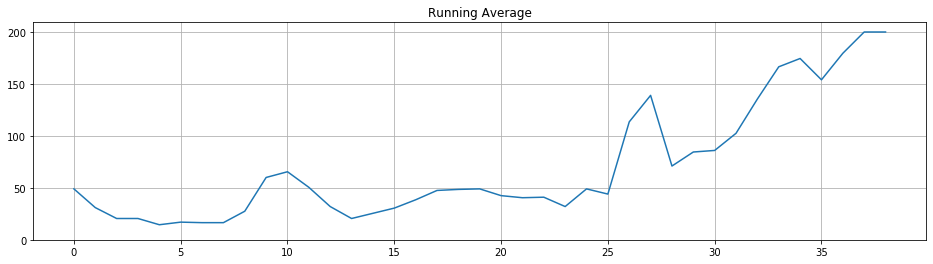

In [13]:
# график роста длительности удержания маятника помере обучения
plot_running_avg(agent.history['score'], window = 1)

In [14]:
lab.test(agent, episodes=5, min_score=195, max_steps=200, verbose=1)

 test:0, score:200
 test:1, score:200
 test:2, score:200
 test:3, score:200
 test:4, score:200
TEST PASSED !


True

In [ ]:
0/0  #interrrupt not to rerun ready parts

# Эксперименты по оптимизации модели и агента.
Сравниваем результаты экспериментов c сетями различных конфигураций и подбираем лучшие гиперпараметры

In [710]:
""" Charting / reporting functions """

def print_agent_performance(history_dump, agent_name):
    agent_histories = [h for h in history_dump if h['name'] == agent_name]
    episode_counts = [h['episodes'] for h in agent_histories]
    episode_times = [h['elapsed_time'] for h in agent_histories]
    successes = [x for x in episode_counts if x < 999]
    cnt = len(successes)
    avg_ep_time = sum(episode_times) / sum(episode_counts)
    avg_solving_time = sum(episode_times) / len(agent_histories)
    success_rate = cnt/len(agent_histories)*100
    mean_episodes = sum(successes) / len(successes)
    max_episodes = max(successes)
    sd = np.std(successes)

    print(f"Agent:{agent_name}, "
          f"N={len(agent_histories)}, "
          f"success:{success_rate:.1f}%, "
          f"mean_ep:{mean_episodes:.0f}, "
          f"max_ep: {max_episodes:.0f}, "
          f"std_dev:{sd:.1f}, "
          f"avg_time:{avg_solving_time:.1f}s "
          )


def display_many_histories(hist_list, score_cap=None):
    agent_names = set([h['name'] for h in hist_list])
    
    for a in agent_names:
        print_agent_performance(hist_list, a)

    if score_cap is None:
        score_cap = max([h['episodes'] for h in hist_list])
    bins = np.arange(0, score_cap, score_cap/20)  # fixed bin size
    
    plt.figure(figsize=(16, 2))
    for i, a in enumerate(agent_names):
        agent_scores = [h['episodes'] for h in hist_list if h['name'] == a]
        plt.xlim(0, score_cap)
        plt.subplot(1, len(agent_names), i+1)
        plt.title(a)
        plt.hist(agent_scores, bins=bins, alpha=0.5)

## Baseline

In [639]:
# тестируем агентов с различными конфигурациями нейросетей

agent32 = Agent_DQN(name="A32", net=NeuralNetwork([32],), optimizer="adam", lr=0.01, 
                    double_dqn=True, update_target_frequency = 500)

agent32s = Agent_DQN(name="A32s", net=NeuralNetwork([32],), optimizer="adam", lr=0.01, 
                     double_dqn=False, update_target_frequency = 500)  #dueling DQN

agent32du = Agent_DQN(name="A32du", net=NeuralNetwork_Dueling(32), optimizer="adam", 
                      lr=0.01, double_dqn=True, update_target_frequency = 500)

agent32_32 = Agent_DQN(name="A32-32", net=NeuralNetwork([32,32]), optimizer="adam",
                       lr=0.01, double_dqn=True, update_target_frequency = 500)

agent64 = Agent_DQN(name="A64", net=NeuralNetwork([64]), optimizer="adam", 
                    lr=0.01, double_dqn=True, update_target_frequency = 500)

agent64s = Agent_DQN(name="A64s", net=NeuralNetwork([64]), optimizer="adam", 
                    lr=0.01, double_dqn=False, update_target_frequency = 500)

agent64o1 = Agent_DQN(name="A64o1", net=NeuralNetwork([64]), optimizer="adam", batch_size=16,
                  lr=0.005, double_dqn=False, update_target_frequency = 200)

agent16 = Agent_DQN(name="A16", net=NeuralNetwork([16]), optimizer="adam", 
                    lr=0.01, double_dqn=True, update_target_frequency = 500)

agents = [agent64o1, agent64s, agent32, agent16, agent64, agent32_32, agent32s, agent32du]

In [ ]:
%%time
""" TESTING DIFFERENT AGENT and NN CONFIGURATIONS """
n_runs = 100

set_history = []

for agent in agents:
    print (f"\nTesting agent {agent.name}:")
    for run in range (n_runs):
        
        print (f"run {run}: ", end="")
        agent.reset()
        lab.train(agent, verbose=0)
        set_history.append(agent.history)
        print (agent.history['episodes'])

    set_1_history = set_history[:]

Agent:A16, N=100, success:97.0%, mean_ep:197, max_ep: 625, std_dev:136.6, avg_time:14.8s 
Agent:A32du, N=100, success:100.0%, mean_ep:195, max_ep: 675, std_dev:109.7, avg_time:18.5s 
Agent:A64, N=100, success:99.0%, mean_ep:229, max_ep: 728, std_dev:127.3, avg_time:17.4s 
Agent:A32s, N=100, success:99.0%, mean_ep:232, max_ep: 924, std_dev:147.7, avg_time:15.6s 
Agent:A32, N=100, success:98.0%, mean_ep:223, max_ep: 807, std_dev:148.5, avg_time:17.0s 
Agent:A32-32, N=100, success:72.0%, mean_ep:281, max_ep: 972, std_dev:212.6, avg_time:35.9s 
999


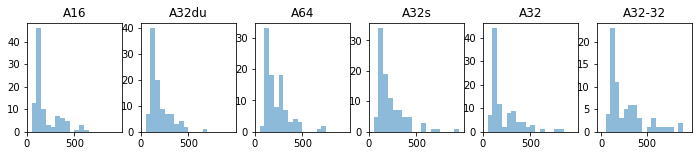

In [706]:
display_many_histories(set_1_history)

относительно хорошие результаты показали: 32 dueling (макс точность) 32 single (быстрая, хорошие точность и дисперсия) 64 double (лучше, чем 32 и 16 double, ниже дисперсия)

Плохо выступила двуслойная сеть (только 72 эксперимента удались и долго работала...)

### NEGATIVE REWARD; split memory for positive/negatie experiences
Включаем разделение в памяти положительных и отрицательных воспоминаний. Добавляем в Lab функцию `transform_run_history` для присвоения отрицательного вознаграждения для последних несколька шагов перед падением

In [ ]:
%%time
""" EXPERIEMENTS TO TEST NEG REWARD """
n_runs = 50
set_history = []

agents = []

name = "N64s"
agent = Agent_DQN(name=name, net=NeuralNetwork([64]), optimizer="adam", batch_size=32,
              lr=0.05, double_dqn=False, update_target_frequency = 500)
agents.append(agent)
    
for agent in agents:
    print (f"\nTesting agent {agent.name}:")
    for run in range (n_runs):
        
        print (f"run {run}: ", end="")
        agent.reset()
        lab.train(agent, verbose=0)
        set_history.append(agent.history)
        print (agent.history['episodes'])

    set_5_history = set_history[:]

In [ ]:
agent16 = Agent_DQN(name="A16", net=NeuralNetwork([16]), optimizer="adam", 
                    lr=0.01, double_dqn=True, update_target_frequency = 500)

In [ ]:
%%time
""" same but with SPLIT MEMORY and faster decay"""
""" EXPERIEMENTS TO TEST DIFFERENT AGENT and NN CONFIGURATIONS """
n_runs = 50

# set_history = []

for agent in agents:
    agent.memory = ReplayMemory4()
    print (f"\nTesting agent {agent.name}:")
    for run in range (n_runs):
        
        print (f"run {run}: ", end="")
        agent.reset()
        e_params = {'start': 1, 'end': 0.01, 'decay': 50}
        lab.train(agent, verbose=0, epsilon_params = e_params)
#         lab.train(agent, verbose=0)
        set_history.append(agent.history)
        print (agent.history['episodes'])
    print_agent_performance (set_history, agent.name)

    set_5_history = set_history[:]

Agent:A16, N=50, success:100.0%, mean_ep:52, max_ep: 84, std_dev:12.5, avg_time:3.2s 
Agent:A64s, N=50, success:100.0%, mean_ep:70, max_ep: 657, std_dev:84.4, avg_time:5.7s 
Agent:A32du, N=50, success:100.0%, mean_ep:54, max_ep: 91, std_dev:13.2, avg_time:4.3s 
Agent:A64, N=50, success:100.0%, mean_ep:57, max_ep: 95, std_dev:13.4, avg_time:4.1s 
Agent:A32s, N=50, success:100.0%, mean_ep:57, max_ep: 82, std_dev:9.6, avg_time:3.3s 
Agent:A64o1, N=50, success:100.0%, mean_ep:43, max_ep: 192, std_dev:22.8, avg_time:3.1s 
Agent:A32, N=50, success:100.0%, mean_ep:57, max_ep: 186, std_dev:21.2, avg_time:4.2s 
Agent:A32-32, N=50, success:100.0%, mean_ep:91, max_ep: 220, std_dev:49.1, avg_time:11.4s 
250


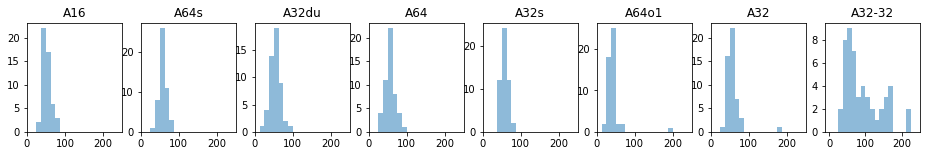

In [696]:
display_many_histories(set_5_history, score_cap = 250)

В результате использования раздельной памяти вдвое сократилось время обучения и снизился разброс результатов. Модель сходится менее, чем за 100 итераций.

относительно хорошие результаты показали:
16 double - использую её для дяльнейших тестов
32 single
другие не сильно отстали

dueling не даёт улучшения дочности 
опять плохо выступила двуслойная сеть...

### test learning rates

In [ ]:
%%time
""" EXPERIEMENTS TO TEST LEARNING RATE """
n_runs = 50

set_history = []

agents = []
for lr in [0.005, 0.01, 0.02, 0.04]:
    name = "A16_lr_"+str(lr)
    agent = Agent_DQN(name=name, net=NeuralNetwork([16]), optimizer="adam", batch_size=32,
                  lr=lr, double_dqn=True, update_target_frequency = 500)
    agents.append(agent)
    
for agent in agents:
    print (f"\nTesting agent {agent.name}:")
    for run in range (n_runs):
        
        print (f"run {run}: ", end="")
        agent.reset()
        e_params = {'start': 1, 'end': 0.01, 'decay': 50}
        lab.train(agent, verbose=0, epsilon_params = e_params)
        set_history.append(agent.history)
        print (agent.history['episodes'])

    set_2_history_b = set_history[:]

Agent:A16_lr_0.005, N=50, success:100.0%, mean_ep:73, max_ep: 429, std_dev:52.0, avg_time:5.2s 
Agent:A16_lr_0.04, N=50, success:100.0%, mean_ep:78, max_ep: 133, std_dev:14.2, avg_time:4.8s 
Agent:A16_lr_0.02, N=50, success:100.0%, mean_ep:76, max_ep: 198, std_dev:22.3, avg_time:4.8s 
Agent:A16_lr_0.01, N=50, success:100.0%, mean_ep:71, max_ep: 151, std_dev:15.7, avg_time:4.3s 


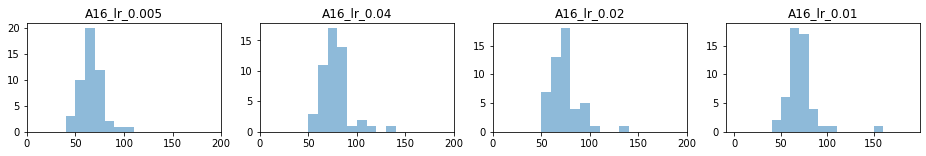

In [754]:
display_many_histories(set_2_history_b, score_cap = 200)

Используем LR=0.01 за лучшие показатели скорости решения и дисперсии (хотя и с малым преимуществом)

### TEST UPDATE FREQUENCY

In [ ]:
%%time
""" EXPERIEMENTS TO TEST UPDATE FREQUENCY """
n_runs = 50
set_history = []

agents = []
for uf in [50, 100, 200, 500, 1000]:
    name = "A16_uf_"+str(uf)
    agent = Agent_DQN(name=name, net=NeuralNetwork([16]), optimizer="adam", batch_size=32,
                  lr=0.01, double_dqn=True, update_target_frequency = uf)
    agents.append(agent)
    
for agent in agents:
    print (f"\nTesting agent {agent.name}:")
    for run in range (n_runs):
        
        print (f"run {run}: ", end="")
        agent.reset()
        e_params = {'start': 1, 'end': 0.01, 'decay': 50}
        lab.train(agent, verbose=0, epsilon_params = e_params)
        set_history.append(agent.history)
        print (agent.history['episodes'])
    print_agent_performance (set_history, agent.name)

    set_3_history = set_history[:]

Agent:A16_uf_50, N=50, success:100.0%, mean_ep:45, max_ep: 94, std_dev:16.3, avg_time:3.5s 
Agent:A16_uf_500, N=50, success:100.0%, mean_ep:52, max_ep: 93, std_dev:12.7, avg_time:3.1s 
Agent:A16_uf_1000, N=50, success:100.0%, mean_ep:86, max_ep: 378, std_dev:62.4, avg_time:7.4s 
Agent:A16_uf_100, N=50, success:100.0%, mean_ep:39, max_ep: 99, std_dev:14.4, avg_time:2.9s 
Agent:A16_uf_200, N=50, success:100.0%, mean_ep:45, max_ep: 202, std_dev:30.3, avg_time:3.8s 


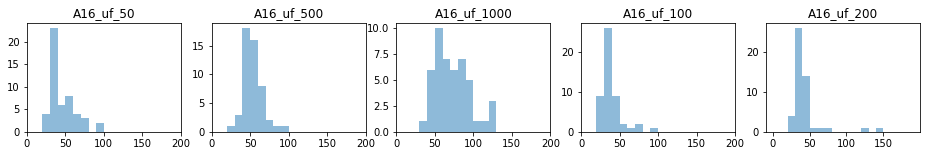

In [755]:
display_many_histories(set_3_history, score_cap = 200)

Снижение частоты обновления НС до 100 увеличивает скорость решения и практически не повышает  дисперсию. Далее используем 100

### Test Batch Size

In [ ]:
%%time
""" EXPERIEMENTS TO TEST BATCH SIZE """
n_runs = 50
set_history = []

agents = []
for bs in [16,32,64,128]:
    name = "A16_bs_"+str(bs)
    agent = Agent_DQN(name=name, net=NeuralNetwork([16]), optimizer="adam", batch_size=bs,
                  lr=0.01, double_dqn=True, update_target_frequency = 100)
    agents.append(agent)
    
for agent in agents:
    print (f"\nTesting agent {agent.name}:")
    for run in range (n_runs):

        print (f"run {run}: ", end="")
        agent.reset()
        e_params = {'start': 1, 'end': 0.01, 'decay': 50}
        lab.train(agent, verbose=0, epsilon_params = e_params)
        set_history.append(agent.history)
        print (agent.history['episodes'])
    print_agent_performance (set_history, agent.name)
 
    set_4_history = set_history[:]

Agent:A16_bs_32, N=50, success:100.0%, mean_ep:42, max_ep: 127, std_dev:21.9, avg_time:3.3s 
Agent:A16_bs_128, N=50, success:100.0%, mean_ep:43, max_ep: 110, std_dev:13.5, avg_time:2.6s 
Agent:A16_bs_16, N=50, success:100.0%, mean_ep:48, max_ep: 117, std_dev:22.7, avg_time:3.2s 
Agent:A16_bs_64, N=50, success:100.0%, mean_ep:37, max_ep: 111, std_dev:14.9, avg_time:2.4s 


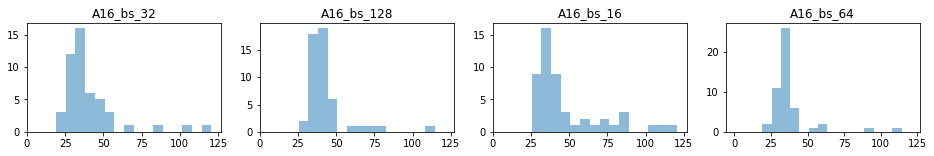

In [729]:
display_many_histories(set_4_history)

наилучшие показатели по скорости и повторяемости у агента с `batch_size=64`. Используем теперь это значение параметра

### Выбор функции оптимизации

In [ ]:
%%time
agent1 = Agent_DQN(name="A16_sgd", net=NeuralNetwork([16]), optimizer="sgd", batch_size=64,
                   lr=0.01, double_dqn=True, update_target_frequency=100)

agent2 = Agent_DQN(name="A16_adam", net=NeuralNetwork([16]), optimizer="adam", batch_size=64,
                   lr=0.01, double_dqn=True, update_target_frequency=100)

agent3 = Agent_DQN(name="A16_rmsp", net=NeuralNetwork([16]), optimizer="rmsprop", batch_size=64,
                   lr=0.01, double_dqn=True, update_target_frequency=100)

agents = [agent1, agent2, agent3]

n_runs = 100
set_history = []

for agent in agents:
    print(f"\nTesting agent {agent.name}:")
    for run in range(n_runs):

        print(f"run {run}: ", end="")
        agent.reset()
        e_params = {'start': 1, 'end': 0.01, 'decay': 50}
        lab.train(agent, verbose=0, epsilon_params=e_params)
        set_history.append(agent.history)
        print(agent.history['episodes'])
    print_agent_performance(set_history, agent.name)

    set_6_history = set_history[:]

Agent:A16_adam, N=100, success:100.0%, mean_ep:41, max_ep: 146, std_dev:17.6, avg_time:3.0s 
Agent:A16_sgd, N=100, success:100.0%, mean_ep:41, max_ep: 126, std_dev:16.9, avg_time:2.6s 
Agent:A16_rmsp, N=100, success:100.0%, mean_ep:44, max_ep: 166, std_dev:24.5, avg_time:3.6s 


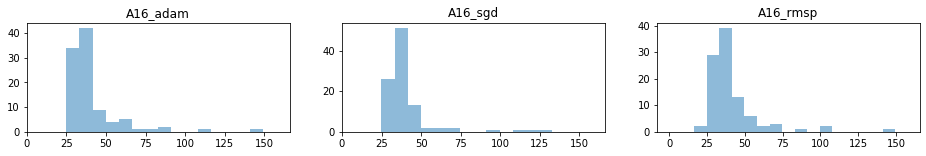

In [750]:
display_many_histories(set_6_history)

Наилучшие результаты показали Adam и SGD (с параметром momentum=0.9). При этом SGD рабтал быстрее. Попробуем теперь использовать его.

### Тест параметра снижения Эпсилон.

`decay:100
Agent:N64_m4, N=50, success:100.0%, mean_ep:74, max_ep: 106, std_dev:11.9, avg_time:3.9s 
Wall time: 3min 25s

decay 20
Agent:N64_m4, N=50, success:100.0%, mean_ep:60, max_ep: 159, std_dev:31.7, avg_time:4.3s 
Wall time: 3min 44s

decay 50:
Agent:N64_m4, N=50, success:100.0%, mean_ep:61, max_ep: 128, std_dev:16.0, avg_time:3.8s 
Wall time: 3min 17s`

тесты показывают возможность снижения decay (ускоряем уменьшение эпсилон) до 50, дальнейшее снижение повышает разброс результатов.

### Тестирование функций потерь

In [ ]:
agent1 = Agent_DQN(name="A16_mse", net=NeuralNetwork([16]), optimizer="sgd", batch_size=64,
                   lr=0.01, double_dqn=True, update_target_frequency=100, loss_func='mse')

agent2 = Agent_DQN(name="A16_sl1", net=NeuralNetwork([16]), optimizer="sgd", batch_size=64,
                   lr=0.01, double_dqn=True, update_target_frequency=100, loss_func='smooth_l1')

agents = [agent1, agent2]
n_runs = 100
set_history = []

for agent in agents:
    print(f"\nTesting agent {agent.name}:")
    for run in range(n_runs):

        print(f"run {run}: ", end="")
        agent.reset()
        e_params = {'start': 1, 'end': 0.01, 'decay': 50}
        lab.train(agent, verbose=0, epsilon_params=e_params)
        set_history.append(agent.history)
        print(agent.history['episodes'])
    print_agent_performance(set_history, agent.name)

    set_7_history = set_history[:]

Agent:A16_sl1, N=100, success:100.0%, mean_ep:45, max_ep: 138, std_dev:18.6, avg_time:3.3s 
Agent:A16_mse, N=100, success:100.0%, mean_ep:42, max_ep: 82, std_dev:10.7, avg_time:3.0s 


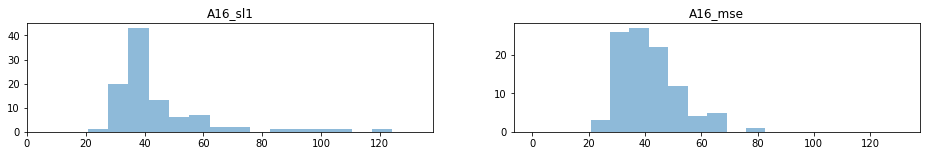

In [761]:
display_many_histories(set_7_history)

### Тестирование параметра гамма

In [ ]:
%%time
""" EXPERIEMENTS TO TEST Gamma """
n_runs = 50
# set_history = []

agents = []
for gamma in [0.5, 0.9, 0.97, 0.99, 0.9999, 1]:
    name = "A16_g"+str(gamma)
    agent = Agent_DQN(name=name, net=NeuralNetwork([16]), optimizer="mse", batch_size=64,
                      lr=0.01, double_dqn=True, update_target_frequency=100, gamma=gamma)
    agents.append(agent)

for agent in agents:
    print(f"\nTesting agent {agent.name}:")
    for run in range(n_runs):

        print(f"run {run}: ", end="")
        agent.reset()
        e_params = {'start': 1, 'end': 0.01, 'decay': 50}
        lab.train(agent, verbose=0, epsilon_params=e_params)
        set_history.append(agent.history)
        print(agent.history['episodes'])
    print_agent_performance(set_history, agent.name)

    set_8_history = set_history[:]

Agent:A16_g0.9999, N=50, success:100.0%, mean_ep:39, max_ep: 192, std_dev:23.9, avg_time:2.9s 
Agent:A16_g0.97, N=50, success:100.0%, mean_ep:47, max_ep: 472, std_dev:62.1, avg_time:5.1s 
Agent:A16_g0.5, N=50, success:98.0%, mean_ep:48, max_ep: 203, std_dev:26.9, avg_time:6.3s 
Agent:A16_g1, N=50, success:100.0%, mean_ep:37, max_ep: 97, std_dev:13.0, avg_time:2.6s 
Agent:A16_g0.9, N=50, success:100.0%, mean_ep:36, max_ep: 71, std_dev:7.3, avg_time:2.3s 
Agent:A16_g0.99, N=50, success:100.0%, mean_ep:38, max_ep: 124, std_dev:13.7, avg_time:2.6s 
Agent:A16_g0.8, N=50, success:100.0%, mean_ep:35, max_ep: 56, std_dev:6.1, avg_time:2.0s 


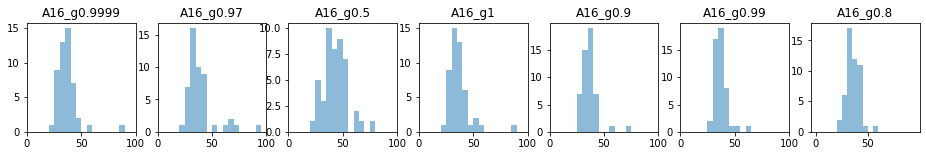

In [767]:
display_many_histories(set_8_history,score_cap = 100)

Параметр `gamma=0.8` показывает наилучшие результаты по скорости и разбросу. Далее использую его.

### повторный тест
После оптимизации гиперпараметров повторно проверим результаты сетей различной архитектуры:

In [ ]:
agent1 = Agent_DQN(name="A16d", net=NeuralNetwork([16]), optimizer="sgd", batch_size=64,
                   gamma=0.8, loss_func='mse',
                   lr=0.01, double_dqn=True, update_target_frequency=100,)

agent2 = Agent_DQN(name="A32d", net=NeuralNetwork([32]), optimizer="sgd", batch_size=64,
                   gamma=0.8, loss_func='mse',
                   lr=0.01, double_dqn=True, update_target_frequency=100)

agent3 = Agent_DQN(name="A16s", net=NeuralNetwork([16]), optimizer="sgd", batch_size=64,
                   gamma=0.8, loss_func='mse',
                   lr=0.01, double_dqn=True, update_target_frequency=100)

agent4 = Agent_DQN(name="A32s", net=NeuralNetwork([32]), optimizer="sgd", batch_size=64,
                   gamma=0.8, loss_func='mse',
                   lr=0.01, double_dqn=False, update_target_frequency=100)

agent5 = Agent_DQN(name="A16due", net=NeuralNetwork_Dueling(16), optimizer="sgd", batch_size=64,
                   gamma=0.8, loss_func='mse',
                   lr=0.01, double_dqn=True, update_target_frequency=100)

agent6 = Agent_DQN(name="A32ds", net=NeuralNetwork_Dueling(32), optimizer="sgd", batch_size=64,
                   gamma=0.8, loss_func='mse',
                   lr=0.01, double_dqn=False, update_target_frequency=100)

agent7 = Agent_DQN(name="A32ds", net=NeuralNetwork_Dueling(32), optimizer="sgd", batch_size=64,
                   gamma=0.8, loss_func='mse',
                   lr=0.01, double_dqn=True, update_target_frequency=100)

agents = [agent1, agent2, agent3, agent4, agent5, agent6]

n_runs = 100
set_history = []

for agent in agents:
    print(f"\nTesting agent {agent.name}:")
    for run in range(n_runs):

        print(f"run {run}: ", end="")
        agent.reset()
        e_params = {'start': 1, 'end': 0.01, 'decay': 50}
        lab.train(agent, verbose=0, epsilon_params=e_params)
        set_history.append(agent.history)
        print(agent.history['episodes'])
    print_agent_performance(set_history, agent.name)

    set_9_history = set_history[:]

Agent:A32d, N=100, success:99.0%, mean_ep:42, max_ep: 96, std_dev:9.8, avg_time:4.7s 
Agent:A32s, N=100, success:100.0%, mean_ep:40, max_ep: 90, std_dev:8.5, avg_time:2.3s 
Agent:A16d, N=100, success:100.0%, mean_ep:42, max_ep: 91, std_dev:10.9, avg_time:2.7s 
Agent:A16s, N=100, success:99.0%, mean_ep:40, max_ep: 77, std_dev:8.6, avg_time:4.0s 


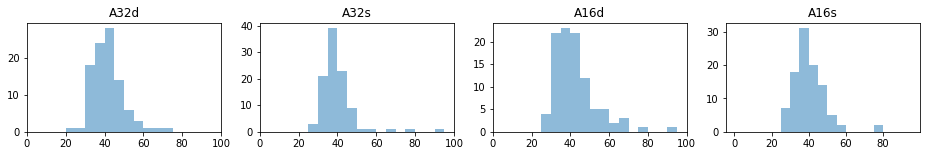

In [770]:
display_many_histories(set_9_history,score_cap = 100)

**ВЫВОДЫ:**

1. Определенные конфигурации сетей показывают значительно более быстрое и уверенное обучение.
2. достигнуто значительное ускорение решения задачи за счёт:
    - применения раздельной памяти опыта
    - оптимизации гиперпараметров модели и агента
    - ускрения снижения параметров Эпсилон
    

# дополнительное исследование: Попытка получать стабильные результаты для сравнения:

Ниже типичная картина для повторяющихся экспериментов. Использованы параметры из Baseline

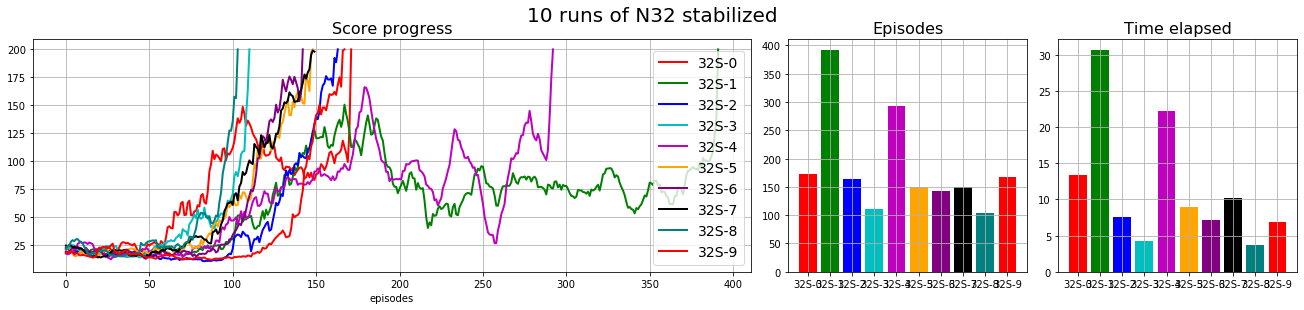

In [29]:
plot_compare(h_stability_2, title="10 runs of N32 stabilized")

Эксперименты (особенно до оптимизации параметров) показывают большой разброс результатов. Хотя для сравнения важно оценивать результаты сетей/агентов в случайных экспериментах, была поставлена промежуточная задача добиться повторяемости экспериментов. 

Сначала тестируем восрпроизводимость отдельных компонентов решения:
- среда
- реакция средын на ход
- генератор сл чисел для сравнения с эпсилоном
- выборка из памяти
- инициализация сетей.

Затем протестируем работу агента в комплексе.

In [121]:
device = torch.device("cpu")

In [771]:
''' функция для инициации случайных генераторов '''
def fix_seeds(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    env.seed(seed)

In [772]:
''' Простая НС '''
class NeuralNetwork_Simple(nn.Module):
    def __init__(self, hidden=32, inputs=number_of_inputs, outputs=number_of_outputs,
                 activation='relu'):
        super(NeuralNetwork_Simple, self).__init__()
        self.linear1 = nn.Linear(inputs, hidden)
        self.linear2 = nn.Linear(hidden, outputs)

    def forward(self, x):
        out1 = F.relu(self.linear1(x))
#         out1 = out1)
        out2 = self.linear2(out1)
        return out2

In [82]:
""" testing ENV """
for e in range (3):
    fix_seeds()
    state = env.reset()
    print(state)

[-0.01258566 -0.00156614  0.04207708 -0.00180545]
[-0.01258566 -0.00156614  0.04207708 -0.00180545]
[-0.01258566 -0.00156614  0.04207708 -0.00180545]


In [83]:
""" testing ENV + moves """
for e in range (3):
    fix_seeds()
    state = env.reset()
    state, reward, done, info = env.step(0)
    state, reward, done, info = env.step(1)
    state, reward, done, info = env.step(0)
    state, reward, done, info = env.step(1)
    print(state)

[-0.02058854 -0.00414739  0.05525604  0.05522   ]
[-0.02058854 -0.00414739  0.05525604  0.05522   ]
[-0.02058854 -0.00414739  0.05525604  0.05522   ]


In [114]:
""" testing epsilon """
for e in range (3):
    fix_seeds()
    for i in range (10):
        epsilon = get_epsilon(i, params=None)
        print (f"{epsilon:.5f}; ", end = "")
    print()

1.00000; 0.99015; 0.98040; 0.97074; 0.96118; 0.95172; 0.94235; 0.93307; 0.92389; 0.91479; 
1.00000; 0.99015; 0.98040; 0.97074; 0.96118; 0.95172; 0.94235; 0.93307; 0.92389; 0.91479; 
1.00000; 0.99015; 0.98040; 0.97074; 0.96118; 0.95172; 0.94235; 0.93307; 0.92389; 0.91479; 


In [159]:
"""Memory test"""
# filling memory
net=NeuralNetwork_Simple()
agent = Agent_DQN2(name=name, net=net, optimizer="adam", 
                     lr=0.01, double_dqn=False, update_target_frequency = 500)
experiment (agent, verbose = 1, max_episodes=10)

for e in range (3):
    fix_seeds()
    s,a,r,s2,d = agent.memory.sample(4)
    print(s[2])

training started for agent '32S-1'...
Elapsed 0.14s, per episode:0.01s, per frame:0.92ms.
tensor([[-0.1015, -1.0158,  0.0691,  1.4571]])
tensor([[-0.1015, -1.0158,  0.0691,  1.4571]])
tensor([[-0.1015, -1.0158,  0.0691,  1.4571]])


In [778]:
class Lab_stable(Lab):
    """ 
    класс с дополнительными вызовами функции сброса seeds
    для тестирования повторяемости
    """                
    def run_episode(self, agent, training=False, epsilon=0, verbose=1):
        state = self.env.reset()
        state = agent.transform_state(state)
        run_history = []
        counter = 0
        done = False
        
        for step in range(1, self.max_steps+1):
            fix_seeds()  # ADDED FIX SEEDS
            action = agent.select_action(state, epsilon)

            new_state, reward, done, info = self.env.step(action)
            new_state = agent.transform_state(new_state)

            if training:
                if done and step < 190:
                    reward = -1.0  
                reward = torch.tensor([reward], device=device)
                fix_seeds()  # ADDED FIX SEEDS
                agent.optimize()
                run_history.append([state, action, new_state, reward, done])
            state = new_state

            if done:
                break
        return step, run_history

In [779]:
""" integrated test """
lab_stable = Lab_stable()
for e in range (3):
    fix_seeds()
    net=NeuralNetwork_Simple()
    agent = Agent_DQN(name="A16d_rep", net=net, optimizer="sgd", batch_size=64,
                       gamma=0.8, loss_func='mse',
                       lr=0.01, double_dqn=True, update_target_frequency=100,)
#     experiment_reproducible (agent, verbose = 2, max_episodes=5)
    agent.reset()
    e_params = {'start': 1, 'end': 0.01, 'decay': 50}
    lab_stable.train(agent, verbose=2, max_episodes=50, epsilon_params=e_params)
#     set_history.append(agent.history)
#     print(agent.history['episodes'])

# TBD

Episode 10: Last 10 average: 15.8; Eps: 0.821, Elapsed: 00:00
Episode 20: Last 10 average: 21.4; Eps: 0.674, Elapsed: 00:01
Episode 30: Last 10 average: 14.9; Eps: 0.553, Elapsed: 00:02
Episode 40: Last 10 average: 87.0; Eps: 0.455, Elapsed: 00:07
SOLVED! After 44 episodes 
Elapsed 11.05s, per episode:0.25s, 
Episode 10: Last 10 average: 18.2; Eps: 0.821, Elapsed: 00:00
Episode 20: Last 10 average: 11.8; Eps: 0.674, Elapsed: 00:01
Episode 30: Last 10 average: 15.0; Eps: 0.553, Elapsed: 00:01
Episode 40: Last 10 average: 30.3; Eps: 0.455, Elapsed: 00:03
Episode 50: Last 10 average: 142.5; Eps: 0.374, Elapsed: 00:11
Elapsed 11.88s, per episode:0.24s, 
Episode 10: Last 10 average: 14.0; Eps: 0.821, Elapsed: 00:00
Episode 20: Last 10 average: 9.5; Eps: 0.674, Elapsed: 00:00
Episode 30: Last 10 average: 16.2; Eps: 0.553, Elapsed: 00:01
Episode 40: Last 10 average: 18.0; Eps: 0.455, Elapsed: 00:02
Episode 50: Last 10 average: 15.7; Eps: 0.374, Elapsed: 00:03
Elapsed 3.60s, per episode:0.07s,

**ВЫВОДЫ**

Хотя все протестированные компоненты дают стабильные результаты, в совокупности агент не обнаруживает повторяемости. Дальнейший поиск причин потребует логирования каждого шага.

В ходе работы над проектом принято решение оценивать результаты агентов на больших выборках, так что решение задачи повторяемости в проекте более не требуется.